In [1]:
#CASO 1: Predicción de la demanda de prdouctos de una empresa, por meses
import pyodbc
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')


In [2]:
sql_server="""
DRIVER={ODBC Driver 17 for SQL Server};
Server=US3RN4M3;
database=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [3]:
query = """
SELECT
    f.OrderDate AS sales_date,
    SUM(f.SalesAmount) AS TotalVentas
FROM
    FactInternetSales AS f
WHERE
	YEAR(f.OrderDate) < 2014
GROUP BY
    f.OrderDate
ORDER BY
    f.OrderDate DESC;
"""

In [4]:
query2 = """
SELECT
    f.OrderDate AS sales_date,
    SUM(f.SalesAmount) AS TotalVentas
FROM
    FactInternetSales AS f
-- WHERE 
--    f.OrderDate <= '2013-12-31'
GROUP BY
    f.OrderDate
ORDER BY
    f.OrderDate DESC;
"""

In [5]:
#Configuración para el entrenamiento (hace referencia a dias)
PASOS = 12

In [6]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantenrr el try para evitar de que
# el programa se rompa
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection


In [7]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [8]:
def series_to_supervised(data, n_in=1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var&d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    n_train_days = int(len(data)) - (30+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    return x_train, y_train, x_val, y_val, scaler, values

In [ ]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh',kernel_regularizer=l2(0.001)))
    # model.add(Dropout(0.3))
    model.compile(loss='mean_absolute_error', optimizer='Adam',metrics=['mse' ])
    model.summary()
    return model

In [11]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model) :
    EPOCHS = 100
    model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)
    model.predict(x_val)
    ultimosDias = data[data.index[int(len(data)*0.70)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = values
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = reframed.values
    x_test = values[len(values)-1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]) )
    return model, x_test

In [12]:
def agregarNuevoValor(x_test, nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test. shape[2]-1] = nuevoValor
    return x_test

In [13]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [14]:
def format_to_date(dates):
    date_format = '%Y-%m-%d'
    status = False
    try: 
        # datetime.strptime(dates['sales_date'],date_format) 
        dates['sales_date'] = pd.to_datetime(dates['sales_date'].str[:10], format='%Y-%m-%d')
        status = True
    except Exception as e: 
        status = False
    
#     if status:
#         return dates
#     else:
#         dates['sales_date'] = dates['sales_date'].astype(str)
# #   Luego aplica la conversión a datetime
        
        return dates

In [15]:

#El Core del sistema
with get_sqlconnection(sql_server) as cursor:
    datos = pd.read_sql_query(query, cursor)

    datos2 = pd.read_sql_query(query2,cursor)
    #habra casos donde el tiempo entregado sea ej 2020-12-31 00:00:00:00
    # Por lo que es conveniente que de todas maneras, hacer un tratamiento de datos para extraer la información
    # datos = format_to_date(datos)
    datos2 = set_index_datetime(datos2)
    datos = set_index_datetime(datos)
    # datos = format_to_date(datos)
    
    #Luego haremos el tratamiento e datos
    # datos.plot()
    print(datos.index)

    #Predicción de acuerdo a la oultima fecha registrada que fue en el 2020-12-31
    # Convertiremos la fecha en un objeto date
    # for i in range(len(datos)):
    #     datos['sales_date'][i] = datetime.strptime(str(datos['sales_date'][i])[:7], '%Y-%m-%d')
    # print(str(datos.index.max()))
    last_day = datetime.strptime(str(datos.index.max()), '%Y-%m-%d %H:%M:%S') #+ relativedelta(months=1)
    print("The last Day is: ",last_day)

    #Predicción que se hará de acierdo a los pasos que se han definido 
    future_days = [last_day + relativedelta(months=i) for i in range(1,PASOS+1)]
    # future_days = [last_day + relativedelta(days=i) for i in range(1, PASOS+1)]
    # print(future_days)

    #Reesctructuramos los datos que se han obtenido, tomando solo los ultimos 10 digitos
    #future_days = [str(i)[:10] for i in future_days]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:7]
        # future_days[i] = str(future_days[i])[:10]
    print(future_days)

    #Cremos un arreglo para poder tomar todas las fechas
    #Que servirá para predecir fechas futuras
    future_data = pd.DataFrame(future_days)
    future_data.columns = ['fecha']
    

    #Creamos un modelo de datos
    model = crear_modeloFF()
    data = []
    for column in datos.columns:
        data = datos.filter([column])
        data.set_index(datos.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        results = []
        for i in range(PASOS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        y_pred = pd.DataFrame(inverted.astype(int))
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)



Conexion establecida satisfactoriamente
DatetimeIndex(['2013-12-31', '2013-12-30', '2013-12-29', '2013-12-28',
               '2013-12-27', '2013-12-26', '2013-12-25', '2013-12-24',
               '2013-12-23', '2013-12-22',
               ...
               '2011-01-07', '2011-01-06', '2011-01-05', '2011-01-04',
               '2011-01-03', '2011-01-02', '2011-01-01', '2010-12-31',
               '2010-12-30', '2010-12-29'],
              dtype='datetime64[ns]', name='sales_date', length=1096, freq=None)
The last Day is:  2013-12-31 00:00:00
['2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12']


C:\Users\JoCel\AppData\Local\Temp\ipykernel_22292\387981538.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos = pd.read_sql_query(query, cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_22292\387981538.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos2 = pd.read_sql_query(query2,cursor)
c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 12)          │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2489 - mse: 0.0925 - val_loss: 0.1687 - val_mse: 0.0489
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2413 - mse: 0.0873 - val_loss: 0.1734 - val_mse: 0.0498
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2247 - mse: 0.0742 - val_loss: 0.1777 - val_mse: 0.0512
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2287 - mse: 0.0776 - val_loss: 0.1689 - val_mse: 0.0505
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2184 - mse: 0.0725 - val_loss: 0.1683 - val_mse: 0.0512
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2258 - mse: 0.0773 - val_loss: 0.1835 - val_mse: 0.0534
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2161 - mse: 0.0676 - val_loss: 0.1861 - val_mse: 0.0541
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2230 - mse: 0.0745 - val_loss: 0.1835 - val_mse: 0.0542
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.211

C:\Users\JoCel\AppData\Local\Temp\ipykernel_22292\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [16]:
print(datos)
datos

            TotalVentas
sales_date             
2013-12-31    1796.8300
2013-12-30    1514.2900
2013-12-29    1834.7900
2013-12-28   48375.3300
2013-12-27   60959.7800
...                 ...
2011-01-02   15012.1782
2011-01-01    7156.5400
2010-12-31   15012.1782
2010-12-30   13931.5200
2010-12-29   14477.3382

[1096 rows x 1 columns]


,TotalVentas
sales_date,
2013-12-31,1796.8300
2013-12-30,1514.2900
2013-12-29,1834.7900
2013-12-28,48375.3300
2013-12-27,60959.7800
...,...
2011-01-02,15012.1782
2011-01-01,7156.5400
2010-12-31,15012.1782


In [17]:
# print(future_data)
# future_data.plot()

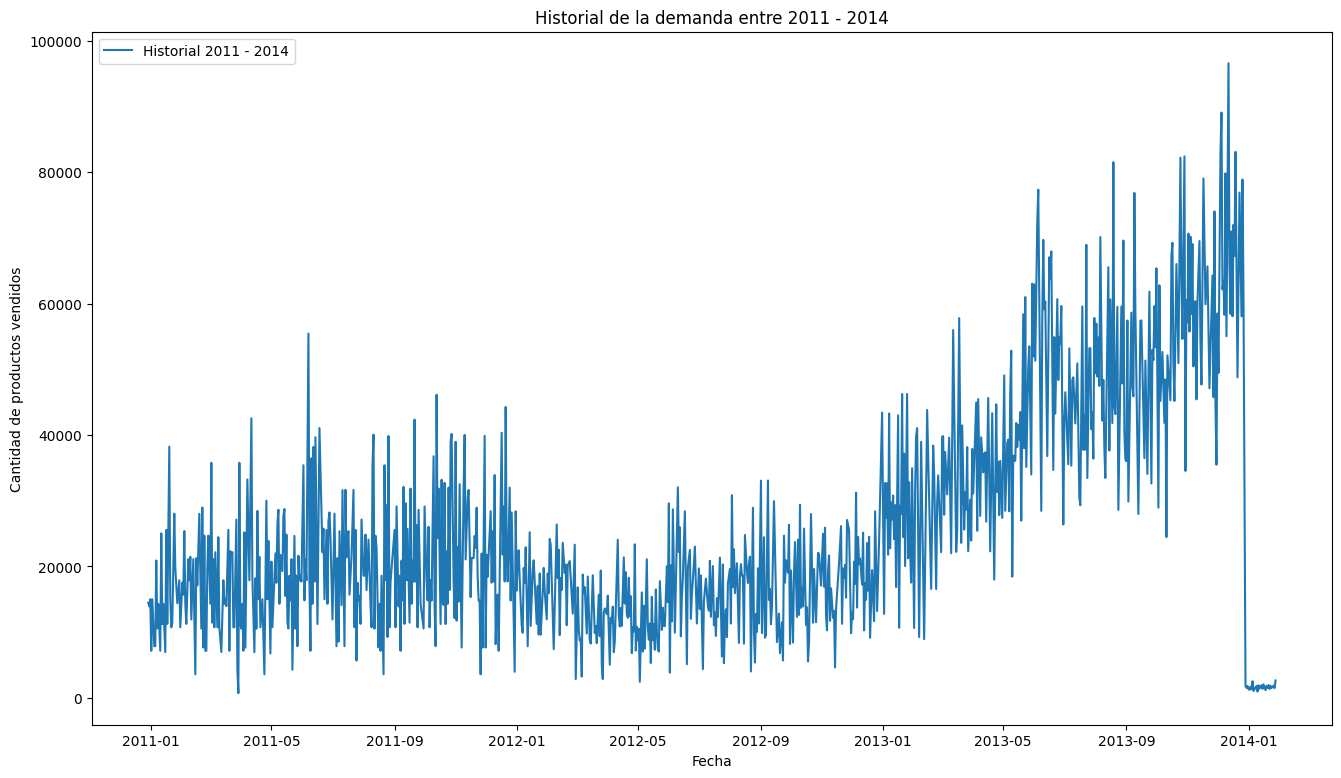

In [18]:
    datos = datos2
    datos.index = pd.to_datetime(datos2.index)
    future_data.index = pd.to_datetime(future_data.index)

    #Graficar los dataframes
    plt.plot(datos.index, datos['TotalVentas'],label='Historial 2011 - 2014')
    # plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción 2021 - 2022')
    # xtics = data.index.union(future_data.index)[::8]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Historial de la demanda entre 2011 - 2014')
    


    plt.legend()
    plt.show()
    # future_data

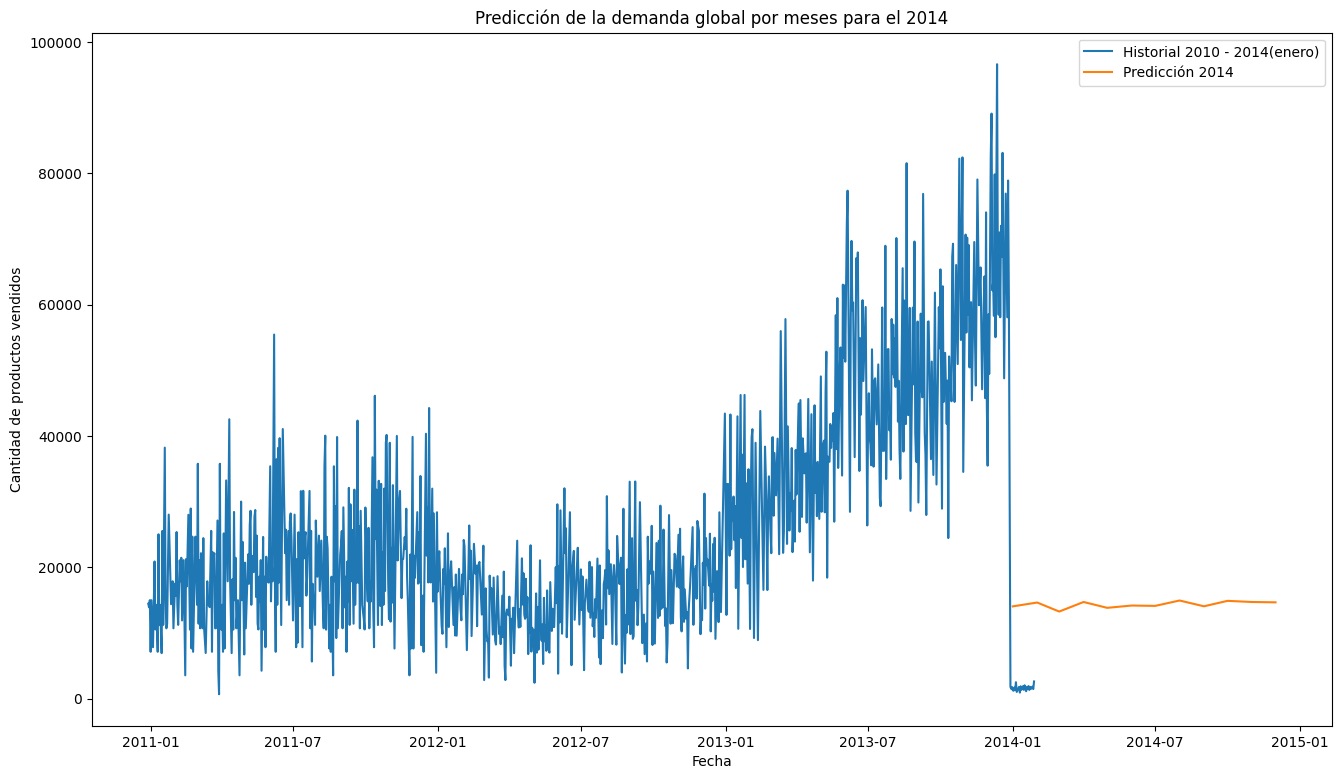

,TotalVentas
fecha,
2014-01-01,14073
2014-02-01,14660
2014-03-01,13285
2014-04-01,14741
2014-05-01,13850
2014-06-01,14201
2014-07-01,14148
2014-08-01,14966
2014-09-01,14086


In [19]:
    #Graficar los dataframes
    plt.plot(datos.index, datos['TotalVentas'],label='Historial 2010 - 2014(enero)')
    plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción 2014 ')
    # xtics = data.index.union(future_data.index)[::8]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Predicción de la demanda global por meses para el 2014')
    


    plt.legend()
    plt.show()
    future_data